In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [43]:
train = pd.read_csv('/Users/zyta/Desktop/kaggle/store-sales-time-series-forecasting/train.csv', parse_dates=['date'])
stores = pd.read_csv('/Users/zyta/Desktop/kaggle/store-sales-time-series-forecasting/stores.csv')
oil = pd.read_csv('/Users/zyta/Desktop/kaggle/store-sales-time-series-forecasting/oil.csv', parse_dates=['date'])
holidays = pd.read_csv('/Users/zyta/Desktop/kaggle/store-sales-time-series-forecasting/holidays_events.csv', parse_dates=['date'])
transactions = pd.read_csv('/Users/zyta/Desktop/kaggle/store-sales-time-series-forecasting/transactions.csv')

# 查看各個資料集的形狀與前幾筆數據
print("Train dataset shape:", train.shape)
print(train.head(), "\n")

print("Stores dataset shape:", stores.shape)
print(stores.head(), "\n")

print("Oil dataset shape:", oil.shape)
print(oil.head(), "\n")

print("Holidays & Events dataset shape:", holidays.shape)
print(holidays.head(), "\n")

print("Transactions dataset shape:", transactions.shape)
print(transactions.head(), "\n")

Train dataset shape: (3000888, 6)
   id       date  store_nbr      family  sales  onpromotion
0   0 2013-01-01          1  AUTOMOTIVE    0.0            0
1   1 2013-01-01          1   BABY CARE    0.0            0
2   2 2013-01-01          1      BEAUTY    0.0            0
3   3 2013-01-01          1   BEVERAGES    0.0            0
4   4 2013-01-01          1       BOOKS    0.0            0 

Stores dataset shape: (54, 5)
   store_nbr           city                           state type  cluster
0          1          Quito                       Pichincha    D       13
1          2          Quito                       Pichincha    D       13
2          3          Quito                       Pichincha    D        8
3          4          Quito                       Pichincha    D        9
4          5  Santo Domingo  Santo Domingo de los Tsachilas    D        4 

Oil dataset shape: (1218, 2)
        date  dcoilwtico
0 2013-01-01         NaN
1 2013-01-02       93.14
2 2013-01-03       92.97

In [45]:
def adjust_holidays(holidays_df):
    """
    根據說明調整假日資料：
    - 預設所有行均標記為假日 (is_real_holiday=1)
    - 如果 transferred 為 True，但 type 不是 'Transfer'，則認為該日期實際上不是慶祝假日，設為 0
    - 將 type 為 'Work Day' 的設為 0（非假日）
    """
    holidays_df = holidays_df.copy()
    holidays_df['is_real_holiday'] = 1
    holidays_df.loc[(holidays_df['transferred'] == True) & (holidays_df['type'] != 'Transfer'), 'is_real_holiday'] = 0
    holidays_df.loc[holidays_df['type'] == 'Work Day', 'is_real_holiday'] = 0
    return holidays_df

def process_data(train, stores, oil, holidays, start_date=None, end_date=None):
    """
    整合並預處理數據：
    - 根據指定日期範圍過濾數據
    - 合併 stores、oil 與 holidays 資料到主數據集
    - 前向填充原油價格缺失值 (假設欄位名稱 'dcoilwtico')
    - 根據 holidays 資料創建二進制假日標記 is_holiday，採用經過調整的 is_real_holiday
    - 新增薪資發放指標 (is_payday)：若該日期為 15 號或月末，則標記為 1
    - 對產品家族進行 one-hot 編碼
    """
    # 依日期範圍篩選
    if start_date:
        train = train[train['date'] >= pd.to_datetime(start_date)]
    if end_date:
        train = train[train['date'] <= pd.to_datetime(end_date)]
    
    # 合併 stores 資料 (以 store_nbr 為鍵)
    df = pd.merge(train, stores, on='store_nbr', how='left')
    
    # 合併 oil 資料 (以 date 為鍵)
    df = pd.merge(df, oil, on='date', how='left')
    if 'dcoilwtico' in df.columns:
        df['dcoilwtico'] = df['dcoilwtico'].fillna(method='ffill')
    
    # 調整並合併 holidays 資料
    holidays_adj = adjust_holidays(holidays)
    holidays_sel = holidays_adj[['date', 'is_real_holiday']]
    df = pd.merge(df, holidays_sel, on='date', how='left')
    df['is_real_holiday'] = df['is_real_holiday'].fillna(0)
    df.rename(columns={'is_real_holiday': 'is_holiday'}, inplace=True)
    
    # 新增薪資發放指標：每月 15 號或月末
    df['is_payday'] = ((df['date'].dt.day == 15) | (df['date'].dt.is_month_end)).astype(int)
    
    # One-hot 編碼產品家族 (family)
    df = pd.get_dummies(df, columns=['family'], prefix='family')
    
    return df

# 使用 process_data() 處理訓練數據，指定日期範圍（根據需要調整）
processed_train = process_data(train, stores, oil, holidays, start_date='2013-01-01', end_date='2017-08-15')

# 檢查處理後數據的部分內容
print("Processed Train Data:")
print(processed_train[['date', 'is_holiday', 'is_payday']].head())

/var/folders/j1/symmvkp556142bj5zm6234rw0000gn/T/ipykernel_1729/3523899441.py:36: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['dcoilwtico'] = df['dcoilwtico'].fillna(method='ffill')


Processed Train Data:
        date  is_holiday  is_payday
0 2013-01-01         1.0          0
1 2013-01-01         1.0          0
2 2013-01-01         1.0          0
3 2013-01-01         1.0          0
4 2013-01-01         1.0          0


In [46]:
# 3. EDA on the Processed Data

# 3.1 Data Overview
print("Processed Train shape:", processed_train.shape)
print(processed_train.head())

Processed Train shape: (3054348, 45)
   id       date  store_nbr  sales  onpromotion   city      state type  \
0   0 2013-01-01          1    0.0            0  Quito  Pichincha    D   
1   1 2013-01-01          1    0.0            0  Quito  Pichincha    D   
2   2 2013-01-01          1    0.0            0  Quito  Pichincha    D   
3   3 2013-01-01          1    0.0            0  Quito  Pichincha    D   
4   4 2013-01-01          1    0.0            0  Quito  Pichincha    D   

   cluster  dcoilwtico  ...  family_MAGAZINES  family_MEATS  \
0       13         NaN  ...             False         False   
1       13         NaN  ...             False         False   
2       13         NaN  ...             False         False   
3       13         NaN  ...             False         False   
4       13         NaN  ...             False         False   

   family_PERSONAL CARE  family_PET SUPPLIES  family_PLAYERS AND ELECTRONICS  \
0                 False                False               

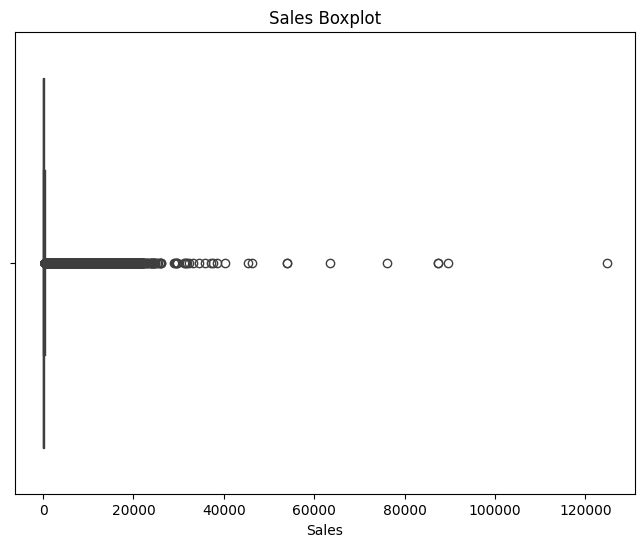

In [47]:
## 3.2.2 Sales Boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x=processed_train['sales'])
plt.title('Sales Boxplot')
plt.xlabel('Sales')
plt.show()


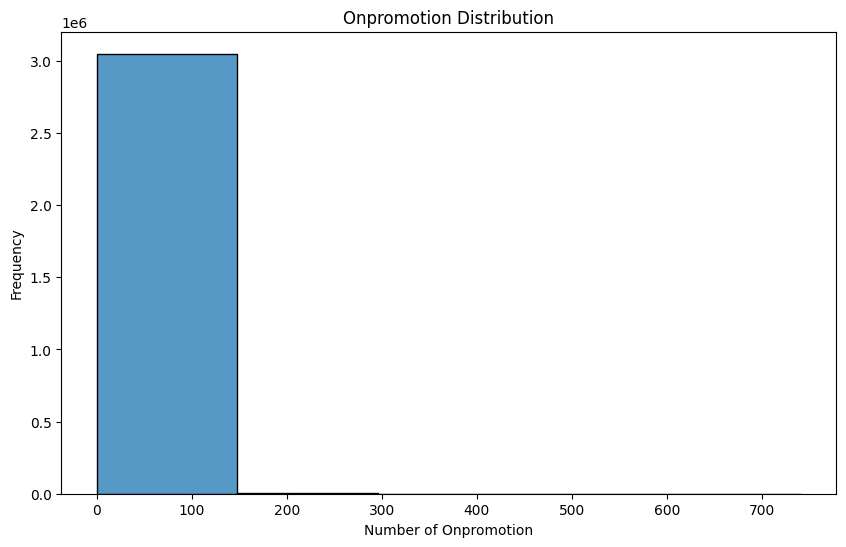

In [48]:
## 3.2.3 Onpromotion Distribution
plt.figure(figsize=(10, 6))
sns.histplot(processed_train['onpromotion'], bins=5, kde=False)
plt.title('Onpromotion Distribution')
plt.xlabel('Number of Onpromotion')
plt.ylabel('Frequency')
plt.show()

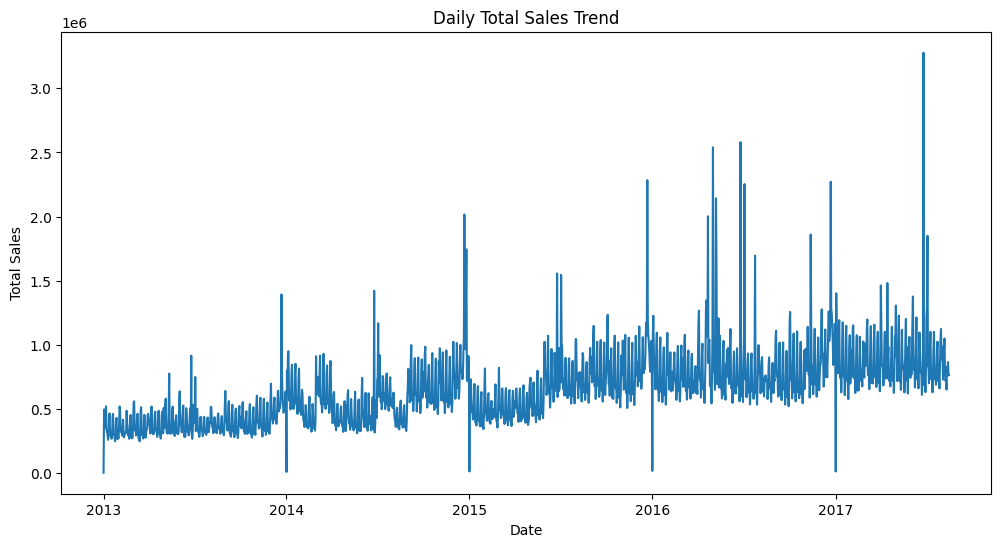

In [49]:
## 3.3.1 Daily Total Sales Trend
daily_sales = processed_train.groupby('date')['sales'].sum().reset_index()
plt.figure(figsize=(12, 6))
sns.lineplot(data=daily_sales, x='date', y='sales')
plt.title('Daily Total Sales Trend')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.show()

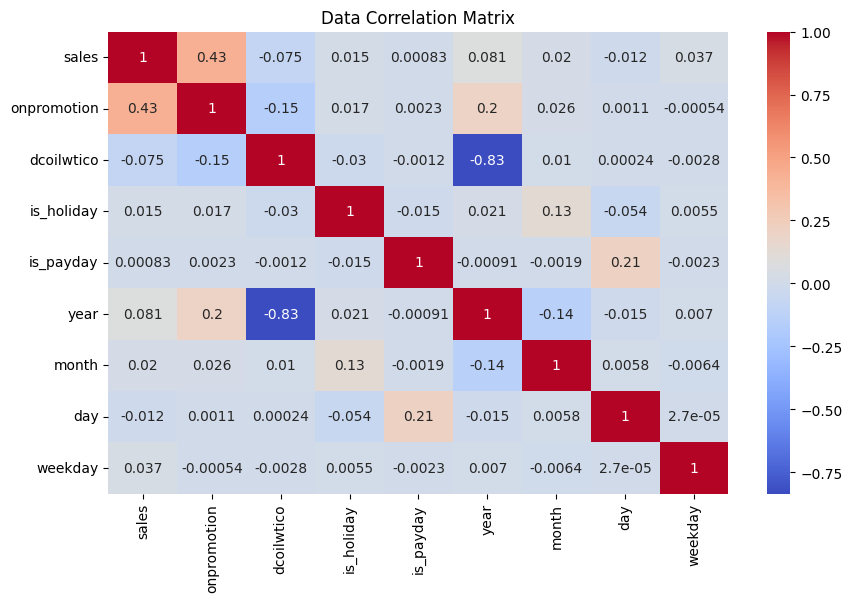

In [52]:
## Extract additional numeric features from the date
processed_train['year'] = processed_train['date'].dt.year
processed_train['month'] = processed_train['date'].dt.month
processed_train['day'] = processed_train['date'].dt.day
processed_train['weekday'] = processed_train['date'].dt.weekday

## Define numeric columns for correlation matrix (including is_payday)
numeric_cols = ['sales', 'onpromotion', 'dcoilwtico', 'is_holiday', 'is_payday', 'year', 'month', 'day', 'weekday']
corr_matrix = processed_train[numeric_cols].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Data Correlation Matrix')
plt.show()

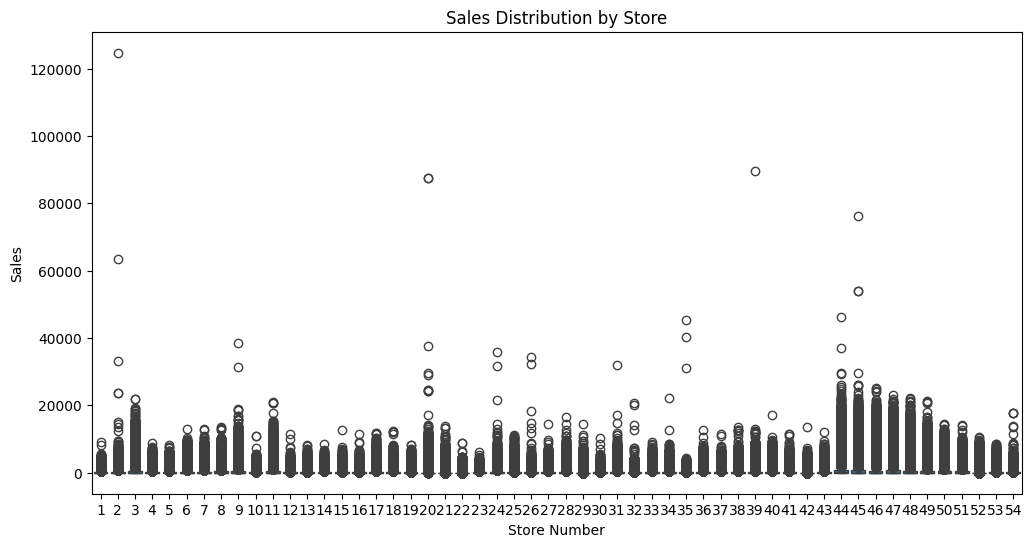

In [37]:
## 3.5.1 Sales Distribution by Store
plt.figure(figsize=(12, 6))
sns.boxplot(data=processed_train, x='store_nbr', y='sales')
plt.title('Sales Distribution by Store')
plt.xlabel('Store Number')
plt.ylabel('Sales')
plt.show()

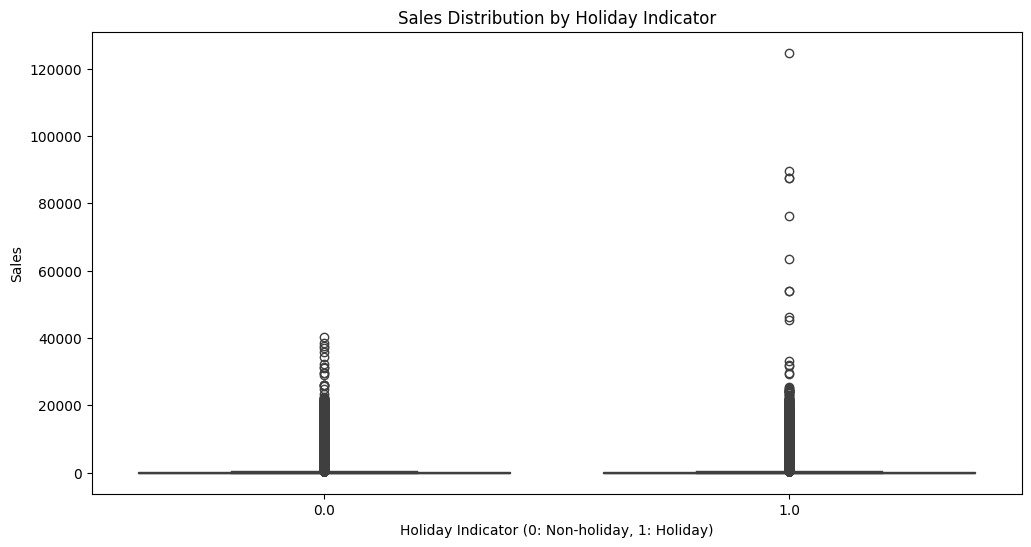

In [38]:
## 3.5.2 Sales Distribution by Holiday Indicator
plt.figure(figsize=(12, 6))
sns.boxplot(data=processed_train, x='is_holiday', y='sales')
plt.title('Sales Distribution by Holiday Indicator')
plt.xlabel('Holiday Indicator (0: Non-holiday, 1: Holiday)')
plt.ylabel('Sales')
plt.show()

Correlation between each product family and Sales:
family_GROCERY I                     0.547820
family_BEVERAGES                     0.325027
family_PRODUCE                       0.159066
family_CLEANING                      0.114173
family_DAIRY                         0.056221
family_BREAD/BAKERY                  0.016784
family_POULTRY                      -0.001268
family_MEATS                        -0.002723
family_PERSONAL CARE                -0.014022
family_DELI                         -0.014910
family_HOME CARE                    -0.029013
family_EGGS                         -0.029924
family_FROZEN FOODS                 -0.032053
family_PREPARED FOODS               -0.041851
family_LIQUOR,WINE,BEER             -0.043626
family_SEAFOOD                      -0.053778
family_GROCERY II                   -0.053859
family_HOME AND KITCHEN I           -0.054031
family_HOME AND KITCHEN II          -0.054632
family_CELEBRATION                  -0.055973
family_LADIESWEAR            

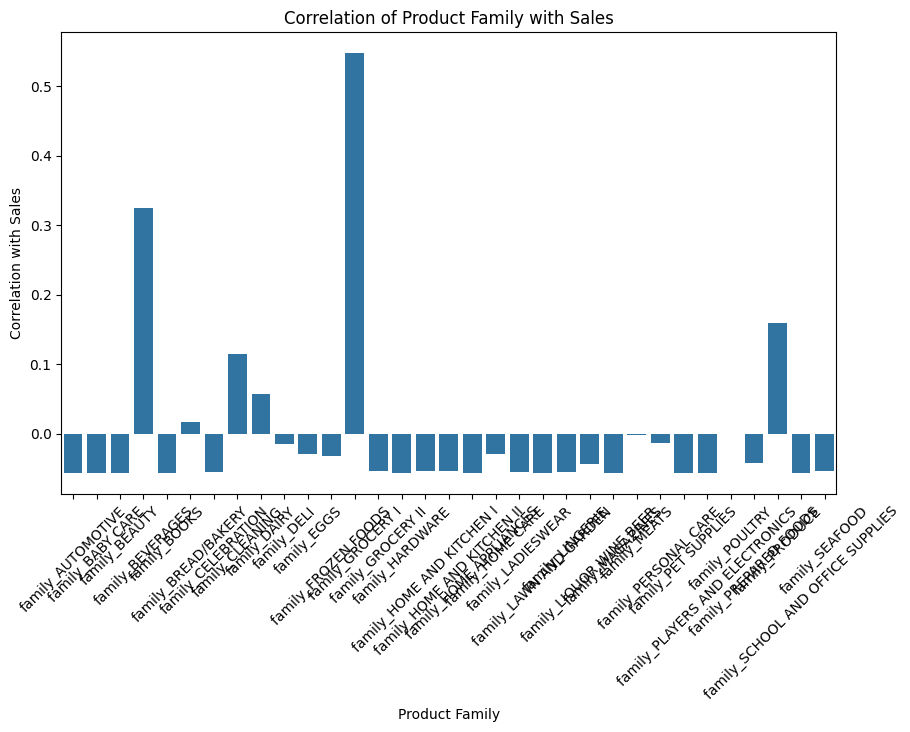

In [39]:
# 假設 processed_train 是處理後的 DataFrame，其中 'family' 已被 one-hot 編碼為多個欄位，欄位名稱以 "family_" 開頭

# 篩選所有與產品家族相關的欄位
family_cols = [col for col in processed_train.columns if col.startswith('family_')]

# 計算這些欄位與 sales 的相關係數
corr_family = processed_train[family_cols + ['sales']].corr()['sales'].drop('sales')

print("Correlation between each product family and Sales:")
print(corr_family.sort_values(ascending=False))

# 繪製條形圖呈現相關係數
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x=corr_family.index, y=corr_family.values)
plt.title("Correlation of Product Family with Sales")
plt.xlabel("Product Family")
plt.ylabel("Correlation with Sales")
plt.xticks(rotation=45)  # 如果類別太多，調整標籤角度以便閱讀
plt.show()

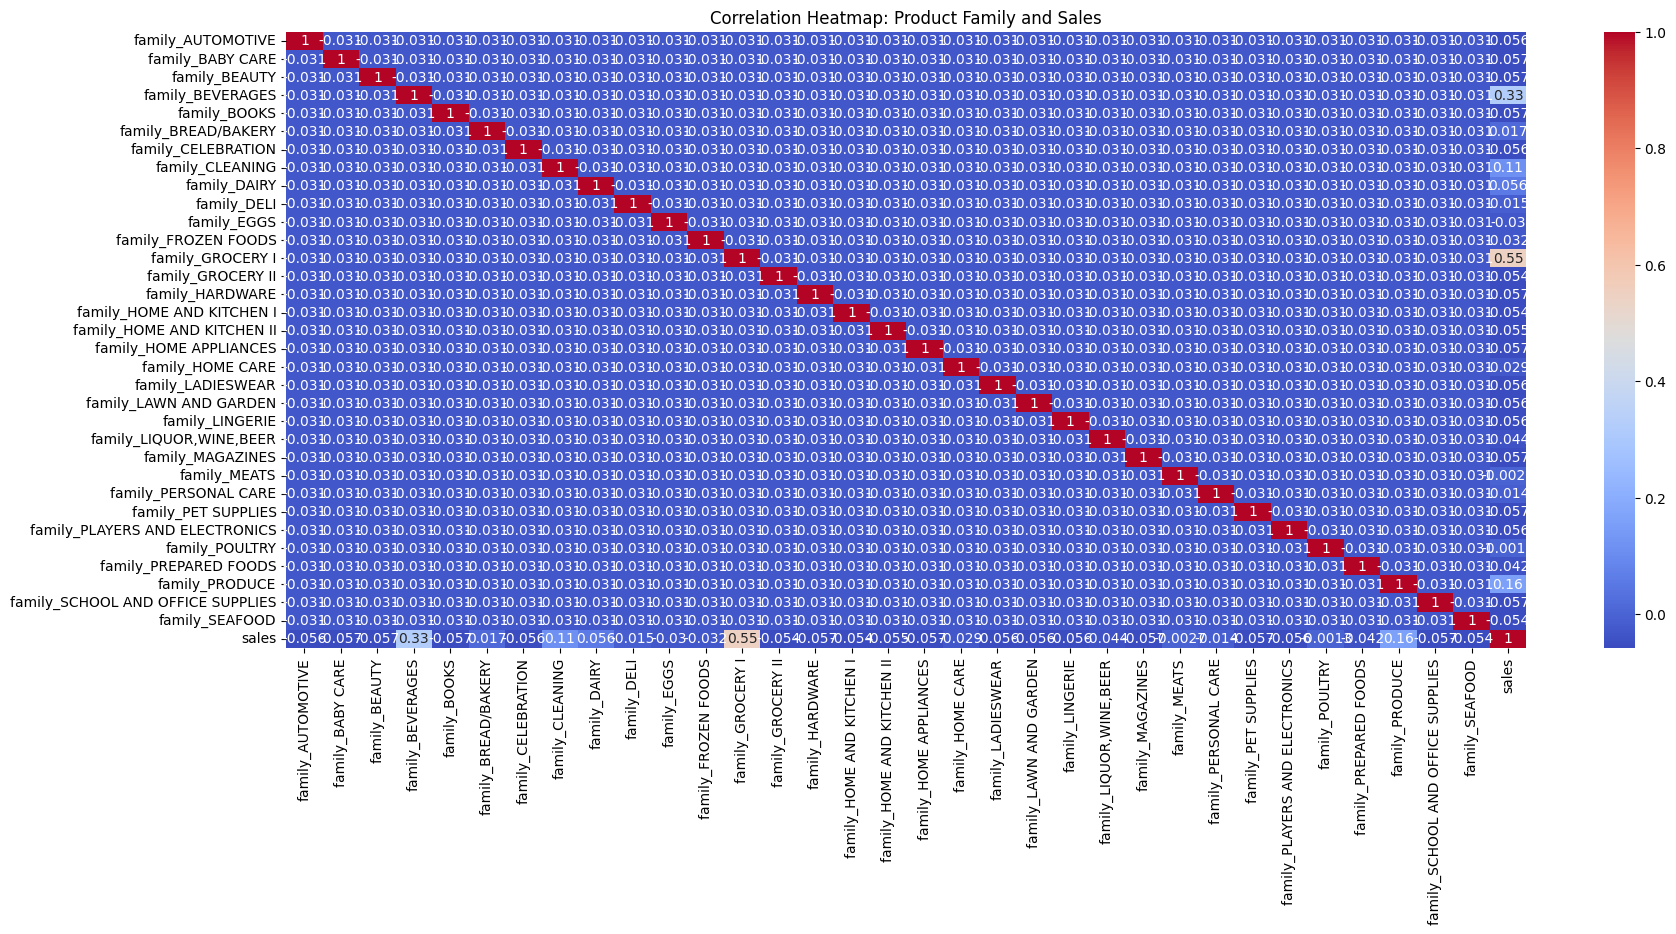

In [40]:
# 篩選所有與產品家族相關的欄位 (假設 one-hot 欄位名稱以 "family_" 開頭)
family_cols = [col for col in processed_train.columns if col.startswith('family_')]

# 計算這些欄位與 sales 的相關矩陣
corr_family_matrix = processed_train[family_cols + ['sales']].corr()

# 使用 heatmap 呈現完整相關矩陣
plt.figure(figsize=(20, 8))
sns.heatmap(corr_family_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap: Product Family and Sales')
plt.show()

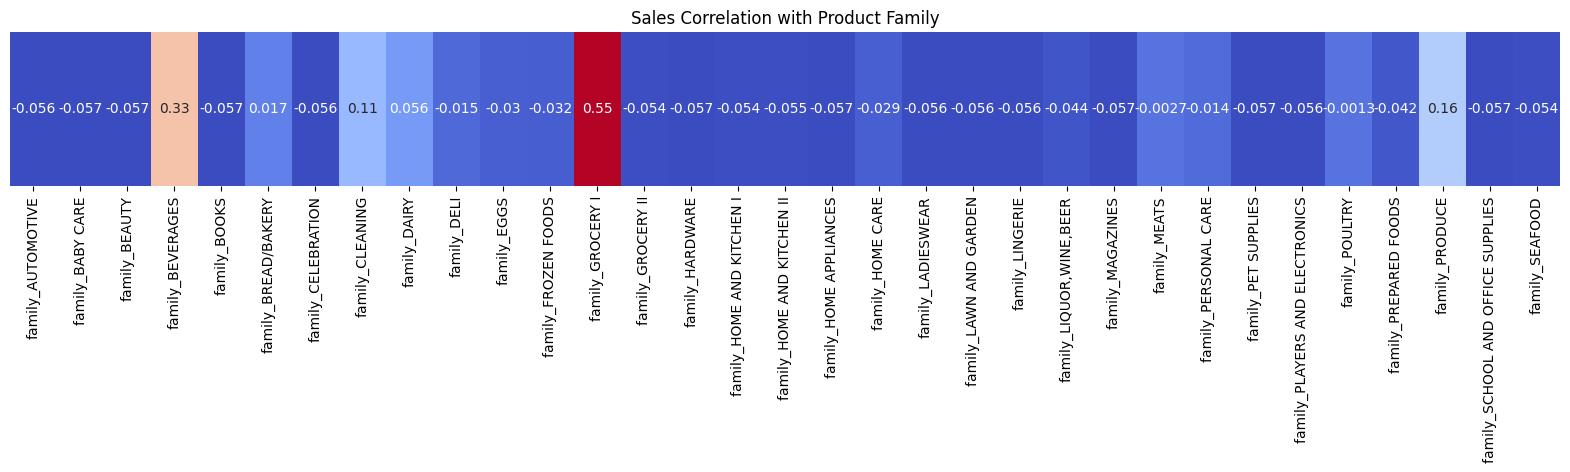

In [24]:
# 同樣取得所有產品家族 one-hot 欄位
family_cols = [col for col in processed_train.columns if col.startswith('family_')]

# 計算相關係數，然後僅取出 sales 與各產品家族之間的相關係數
corr_family_series = processed_train[family_cols + ['sales']].corr()['sales'].drop('sales')

# 將 Series 轉換成 DataFrame，方便使用 heatmap 呈現單行數據
corr_family_df = corr_family_series.to_frame().T

plt.figure(figsize=(20, 2))
sns.heatmap(corr_family_df, annot=True, cmap='coolwarm', cbar=False)
plt.title('Sales Correlation with Product Family')
plt.yticks([])  # 移除 y 軸標籤
plt.show()